[View in Colaboratory](https://colab.research.google.com/github/kintarou/django-starter/blob/master/gaussian_process_regression.ipynb)

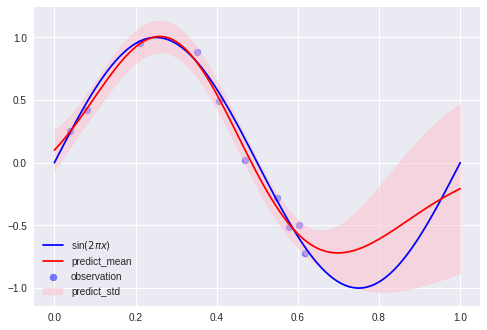

In [1]:
import matplotlib.pyplot as plt
import numpy as np


class GaussianKernel(object):

    def __init__(self, params):
        assert np.shape(params) == (2,)
        self.__params = params

    def get_params(self):
        return np.copy(self.__params)

    def __call__(self, x, y):
        return self.__params[0] * np.exp(-0.5 * self.__params[1] * (x - y) ** 2)

    def derivatives(self, x, y):
        sq_diff = (x - y) ** 2
        delta_0 = np.exp(-0.5 * self.__params[1] * sq_diff)
        delta_1 = -0.5 * sq_diff * delta_0 * self.__params[0]
        return (delta_0, delta_1)

    def update_parameters(self, updates):
        assert np.shape(updates) == (2,)
        self.__params += updates


class GaussianProcessRegression(object):

    def __init__(self, kernel, beta=1.):
        self.kernel = kernel
        self.beta = beta

    def fit(self, x, t):
        self.x = x
        self.t = t
        Gram = self.kernel(*np.meshgrid(x, x))
        self.covariance = Gram + np.identity(len(x)) / self.beta
        self.precision = np.linalg.inv(self.covariance)

    def fit_kernel(self, x, t, learning_rate=0.1, iter_max=10000):
        for i in range(iter_max):
            params = self.kernel.get_params()
            self.fit(x, t)
            gradients = self.kernel.derivatives(*np.meshgrid(x, x))
            updates = np.array(
                [-np.trace(self.precision.dot(grad)) + t.dot(self.precision.dot(grad).dot(self.precision).dot(t)) for grad in gradients])
            self.kernel.update_parameters(learning_rate * updates)
            if np.allclose(params, self.kernel.get_params()):
                break
        else:
            print("parameters may not have converged")

    def predict_dist(self, x):
        K = self.kernel(*np.meshgrid(x, self.x, indexing='ij'))
        mean = K.dot(self.precision).dot(self.t)
        var = self.kernel(x, x) + 1 / self.beta - np.sum(K.dot(self.precision) * K, axis=1)
        return mean.ravel(), np.sqrt(var.ravel())


def create_toy_data(func, low=0, high=1., n=10, std=1.):
    x = np.random.uniform(low, high, n)
    t = func(x) + np.random.normal(scale=std, size=n)
    return x, t


def main():

    def func(x):
        return np.sin(2 * np.pi * x)

    x, t = create_toy_data(func, high=0.7, std=0.1)

    kernel = GaussianKernel(params=np.array([1., 1.]))
    regression = GaussianProcessRegression(kernel=kernel, beta=100)
    regression.fit_kernel(x, t, learning_rate=0.1, iter_max=10000)

    x_test = np.linspace(0, 1, 100)
    y, y_std = regression.predict_dist(x_test)

    plt.scatter(x, t, alpha=0.5, color="blue", label="observation")
    plt.plot(x_test, func(x_test), color="blue", label="sin$(2\pi x)$")
    plt.plot(x_test, y, color="red", label="predict_mean")
    plt.fill_between(x_test, y - y_std, y + y_std, color="pink", alpha=0.5, label="predict_std")
    plt.legend(loc="lower left")
    plt.show()

if __name__ == '__main__':
    main()